In [17]:
%run ../aux_funcs.py
%run ../RSRG.py
%run ../RSRG_class.py
#from iminuit import cost, Minuit

In [2]:
def linear_fit(x, m, b):
    return m*x+b

In [ ]:
L = 40
steps = 1400
measure_step = 10

a_vals = np.array([0.1])#np.arange(0.05, 0.2, 0.02)
b_vals = np.array([0.105])#np.arange(0.1,0.3,0.03)

J_ij_vals, h_vals, R0_array, mu_array = run_decimation(L, steps, measure_step, a_vals, b_vals, track_moments=True)

In [ ]:
x = L*L - np.arange(len(R0_array))*measure_step
y = 1/np.array(R0_array)
R_length = len(y)

plt.scatter(x, y, label='Width of exponential')#, yerr=np.sqrt(np.array(R0_array_err))/np.array(R0_array)**2)
#plt.yscale('log')

popt, pcov = curve_fit(power_law_scale, x[int(R_length/2):], y[int(R_length/2):])
print(popt)
print(popt[0]*2)

plt.title("RG Flow of Field Distribution Scaling")
plt.xlabel("Remaining Spins (N)")
plt.ylabel(r"$1/R_0(\Gamma)$")
plt.plot(x, power_law_scale(x, *popt), color='red', label=r'Power Law fit ($\psi=$'+str(round(popt[0]*2, 4))+')')

plt.gca().invert_xaxis()
plt.legend()
plt.yscale('log')
#plt.ylim(0, 1.5)

In [ ]:
x = np.log(L*L - np.arange(len(R0_array))*measure_step)
y = np.log(mu_array)
R_length = len(y)

plt.scatter(x, y, label='Average moments')#, yerr=np.sqrt(np.array(R0_array_err))/np.array(R0_array)**2)
#plt.yscale('log')

popt, pcov = curve_fit(linear_fit, x[int(R_length/100):], y[int(R_length/100):])
print(popt)

plt.title("Scaling of Cluster moments")
plt.xlabel("Log Remaining Spins (N)")
plt.ylabel(r"Log $(\mu)$")
plt.plot(x, linear_fit(x, *popt), color='red', label=r'Linear Fit')

plt.gca().invert_xaxis()
plt.legend()

#plt.ylim(0, 1.5)

In [ ]:
L = 60
steps = int(0.99*L*L)
a, b = 0.1, 0.105
measure_step = 30

ind_dict, adj_ind = triangle_lattice_dictionary(L)
nn_ind = triangle_nn_indices(L)
nnn_ind = triangle_nnn_indices(L)

measure_list = np.floor(steps*(1/(1.1**np.arange(1,60))))
measure_list = measure_list.astype(int)
check_list = np.floor(L*L*(1- 1/(1.6**np.arange(10))))

runs = 1

In [ ]:
a_vals = np.array([0.02, 0.04, 0.06, 0.08, 0.1, 0.12])
b_vals = np.array([0.06])

a_list = np.zeros(shape=(len(a_vals), 1+int(steps/measure_step)))
b_list = np.zeros(shape=(len(b_vals), 1+int(steps/measure_step)))
R0_array = np.zeros(shape=(len(a_vals), 1+int(steps/measure_step)))

for run in range(runs):  
    for a_ind, a in enumerate(a_vals):
    #for b_ind, b in enumerate(b_vals):
        J_ij_vals = fill_J_ij_matrix(L*L, nn_ind, nnn_ind, a, b)
        h_vals = np.exp(-np.random.exponential(size=L*L))
        test = system(L*L, adj_ind, J_ij_vals, h_vals)   

        for i in range(steps):
            test.decimate()
            if i%measure_step==0:  #(L*L-i) in measure_list:#
                ind = int(i/measure_step)#np.where(measure_list==(L*L-i))
                R0_array[a_ind, ind] += extract_width(test.h_vals, test.Omega)
                #R0_array[b_ind, ind] += m.values[0]
                
                a_sc = a/9
                b_sc = b/9
                #print(i)
                J_remain = -np.log(sparse.find(test.J_ij_vals)[2])
                x = np.linspace(0, (np.sqrt(a_sc**2 + 2*b_sc) - a_sc)/b_sc, len(J_remain))

                n,bins = np.histogram(J_remain, density = 'True', bins=30)
                width = bins[1]-bins[0]
                popt, pcov = curve_fit(linDist, (bins[1:]-width/2), n)
                a_list[a_ind, ind] += popt[0]
                #b_list[b_ind, ind] += popt[1]
                #plt.plot(x, np.array(linDist(x, *popt)))
                """
                if i in check_list:
                    h_remain = test.h_vals
                    h_remain = h_remain[h_remain!=0]
                    n,bins = np.histogram(-np.log(h_remain/test.Omega), density=True, bins = 60)
                    width = bins[1]-bins[0]

                    popt, pcov = curve_fit(exponential_dist_norm, (bins[1:]-width/2)[:20], n[:20])
                    plt.scatter(bins[1:]-width/2, n, label="N="+str(L*L - i), s=10)
                    plt.plot(bins[1:]-width/2, exponential_dist_norm(bins[1:]-width/2, *popt))
                """
            if False:#i in check_list:
                a_sc = a/9
                b_sc = b/9
                #print(i)
                J_remain = -np.log(sparse.find(test.J_ij_vals)[2])
                x = np.linspace(0, (np.sqrt(a_sc**2 + 2*b_sc) - a_sc)/b_sc, len(J_remain))

                n,bins,patches = plt.hist(J_remain, density = 'True', bins=30)
                width = bins[1]-bins[0]
                popt, pcov = curve_fit(linDist, (bins[1:]-width/2), n)
                a_list[a_ind, np.where(check_list==i)[0][0]] = popt[0]
                plt.plot(x, np.array(linDist(x, *popt)))
                

#plt.xscale('log')
"""
plt.xlabel(r"Log field coupling $\beta$")
plt.ylabel(r"Distribution $R(\beta)$")
plt.title("Distribution of Field Couplings")
plt.yscale('log')
plt.xlim(0.01, 4)
plt.legend()
plt.ylim(0.01, 1)
"""

In [ ]:
x = L*L - np.arange(1+int(steps/measure_step))*measure_step
for b_ind, b in enumerate(b_vals):
    y = b_list[b_ind,:]*9/R0_array[b_ind,:]
    plt.plot(x, y, marker='o', label="("+str(a)+","+str(b)+")")
plt.gca().invert_xaxis()
plt.xscale('log')
plt.ylim(-0.2, 0.5)

plt.title("RG Flow of Bond Couplings")
plt.xlabel("Remaining Spins")
plt.ylabel(r" Scaled slope parameter $P(0)/R_0$")

plt.legend()

In [ ]:
x = L*L - np.arange(1+int(steps/measure_step))*measure_step
for a_ind, a in enumerate(a_vals):
    y = a_list[a_ind,:]*9/R0_array[a_ind,:]
    plt.plot(x, y, marker='o', label="("+str(a)+","+str(b)+")")
plt.gca().invert_xaxis()
plt.xscale('log')
plt.ylim(-0.2, 0.5)

plt.title("RG Flow of Bond Couplings")
plt.xlabel("Remaining Spins")
plt.ylabel(r" Scaled intercept parameter $P(0)/R_0$")

plt.legend()

In [ ]:
x = L*L - np.arange(1+int(steps/measure_step))*measure_step

R_length = len(y)

start = 37
end = 45

plt.axvline(x = x[start])
plt.axvline(x = x[end])

for a_ind, a in enumerate(a_vals):
    y = runs/R0_array[a_ind,:]
    plt.scatter(x, y, label="("+str(a)+","+str(b)+")")#, yerr=np.sqrt(np.array(R0_array_err))/np.array(R0_array)**2)


#plt.yscale('log')

popt, pcov = curve_fit(power_law_scale, x[start:end], y[start:end])
print(popt)
print(popt[0]*2)

plt.title("RG Flow of Field Distribution Scaling")
plt.xlabel("Remaining Spins (N)")
plt.ylabel(r"$1/R_0(\Gamma)$")
plt.plot(x, power_law_scale(x, *popt), color='red', label=r'Power Law fit ($\psi=$'+str(round(popt[0], 4))+')')

plt.gca().invert_xaxis()
plt.legend()
plt.yscale('log')
plt.xscale('log')

#plt.xlim(1e4, 0.8*1e3)

In [18]:
L = 40
steps = int(0.95*L*L)
a, b = 0.1, 0.105
measure_step = 1

ind_dict, adj_ind = triangle_lattice_dictionary(L)
nn_ind = triangle_nn_indices(L)
nnn_ind = triangle_nnn_indices(L)

measure_list = np.floor(steps*(1/(1.1**np.arange(1,60))))
measure_list = measure_list.astype(int)
check_list = np.floor(L*L*(1- 1/(1.6**np.arange(10))))

runs = 1
import time

In [19]:
a_vals = np.array([0.1])
b_vals = np.array([0.105])

a_list = np.zeros(shape=(len(a_vals), 1+int(steps/measure_step)))
b_list = np.zeros(shape=(len(b_vals), 1+int(steps/measure_step)))
R0_array = np.zeros(shape=(len(a_vals), 1+int(steps/measure_step)))

t0 = time.time()
for run in range(runs):  
    for a_ind, a in enumerate(a_vals):
    #for b_ind, b in enumerate(b_vals):
        J_ij_vals = fill_J_ij_matrix(L*L, nn_ind, nnn_ind, a, b)
        h_vals = np.exp(-np.random.exponential(size=L*L))
        test = system(L*L, adj_ind, J_ij_vals, h_vals)   

        for i in range(steps):
            test.decimate()
            if i%measure_step==0:  #(L*L-i) in measure_list:#
                ind = int(i/measure_step)#np.where(measure_list==(L*L-i))
                R0_array[a_ind, ind] += test.extract_width()
                
                
print(time.time()-t0)

30.315779209136963


In [28]:
len(test.R0_array)

76

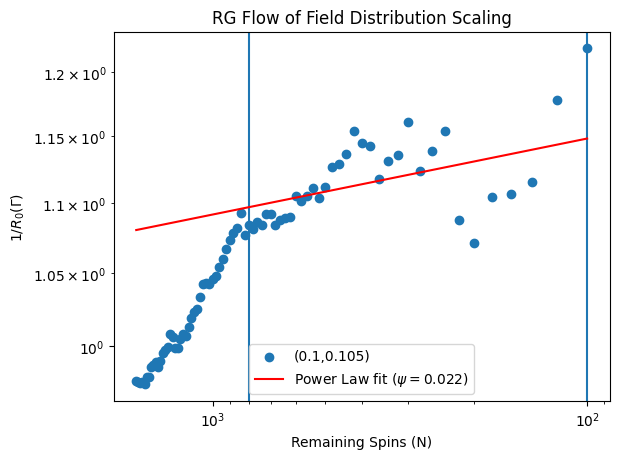

In [29]:
measure_step = 20
x = L*L - np.arange(int(steps/measure_step))*measure_step

#R_length = len(y)

start = 40
end = -1

plt.axvline(x = x[start])
plt.axvline(x = x[end])

for a_ind, a in enumerate(a_vals):
    y = runs/  np.array(test.R0_array)#R0_array[a_ind,:]
    plt.scatter(x, y, label="("+str(a)+","+str(b)+")")#, yerr=np.sqrt(np.array(R0_array_err))/np.array(R0_array)**2)


#plt.yscale('log')

popt, pcov = curve_fit(power_law_scale, x[start:end], y[start:end])


plt.title("RG Flow of Field Distribution Scaling")
plt.xlabel("Remaining Spins (N)")
plt.ylabel(r"$1/R_0(\Gamma)$")
plt.plot(x, power_law_scale(x, *popt), color='red', label=r'Power Law fit ($\psi=$'+str(round(popt[0], 4))+')')

plt.gca().invert_xaxis()
plt.legend()
plt.yscale('log')
plt.xscale('log')

#plt.xlim(1e4, 0.8*1e3)

In [ ]:
def extract_width(hs, Om):
    h_left = hs[hs!=0]
    c = cost.UnbinnedNLL(-np.log(h_left/Om), exponential_dist_norm)
    m = Minuit(c, a=0.8)
    m.migrad()
    return m.values[0]